In [3]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [4]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
import glob, os
from matplotlib.patches import Rectangle

In [5]:
sys.path.append("../../../../scripts/python/")

In [6]:
import RNAseq
importlib.reload(RNAseq)

<module 'RNAseq' from '/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/RNAseq.py'>

In [7]:
annot_path = "../../../../data/public/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"

### Plotting parameters

In [8]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

In [9]:
# cell line
b = {"BT20" : "dodgerblue", "HCC70" : "rebeccapurple", "MDAMB231": "seagreen", "MDAMB436": "tab:olive", "SKBR3": "palevioletred", "MCF7-atcc":"brown", "MCF7-labbo":"gold","ZR75":"chocolate","T47D":"gray"}

In [10]:
b.keys()

dict_keys(['BT20', 'HCC70', 'MDAMB231', 'MDAMB436', 'SKBR3', 'MCF7-atcc', 'MCF7-labbo', 'ZR75', 'T47D'])

### Loading datasets

#### BULK LAB

In [12]:
t47d = RNAseq.bulk_Dataset(project_path="/home/arion/davidm/Data/datasets/private/RNA-seq/bulk/bulk-T47D_DSP280", quant_tool = "salmon", genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34", quant_params = "raw-reads/pc-decoys-k31-1.4.0", pp = '', samples_id = "conditions", samples = "shNT", cdna = "full length")
t47d.annotate_samples(samples_annot_name = "cell_lines", samples_annot = "T47D")
t47d.save()

Annotating conditions...
Annotating cell_lines...


In [15]:
mcf7 = RNAseq.bulk_Dataset(project_path="/home/arion/davidm/Data/datasets/private/RNA-seq/bulk/bulk-MCF7_DSP356", quant_tool = "salmon", genref = "human/assembly__GRCh38-hg38/annotation__ensembl/ensembl_100", pp = '', samples_id = "conditions", samples = "E", cdna = "full length")
mcf7.annotate_samples(samples_annot_name = "cell_lines", samples_annot = "MCF7")
mcf7.select_samples(samples_annot_name="replicates", samples_annot = '1')
mcf7.save()

Annotating conditions...
Annotating replicates...
Annotating cell_lines...


#### BULK PANEL

In [11]:
panel = RNAseq.bulk_Dataset(project_path="/home/arion/davidm/Data/datasets/public/RNA-seq/bulk/BC-Cell-Lines-Panel_GSE48213", quant_tool = "salmon", genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34", quant_params = "raw/pc-decoys-k31-1.4.0", pp = '', samples_id = "cell_lines", samples = "all", cdna = "full length")
panel.save()

Annotating cell_lines...


In [20]:
panel.mtx.shape

(56, 20305)

#### Merge bulks

In [23]:
bulk = RNAseq.merge_datasets(list_datasets=[t47d, mcf7, panel], annot_name="dataset", annot=["bulk-lab", "bulk-lab", "bulk-56"])
bulk.annotate_genes(genes_annot_name = "external_gene_name", save_path = annot_path + "/biomart_ens100")
bulk.annotate_genes(genes_annot_name = "exonic_length", compute_length = {"start" : "exon_chrom_start", "stop" : "exon_chrom_end"}, save_path = annot_path + "/biomart_ens100")
bulk.downsample(11000000)
bulk.save()

Annotating dataset...
Annotating cell_lines...
Annotating external_gene_name using /home/arion/davidm/Data/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/biomart_ens100/ensembl_gene_id-to-external_gene_name.csv...
Annotating exonic_length using /home/arion/davidm/Data/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/biomart_ens100/ensembl_gene_id-to-exonic_length.csv...


In [24]:
bulk.mtx.shape

(58, 20153)

In [ ]:
bulk.reload()
bulk.mtx.sum(1)

#### SC

In [12]:
sc1 = RNAseq.sc_Dataset(project_path = "/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-BC-cell-lines_DSP992", samples_id = "cell_lines", samples= 'all', quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "filtered/stringent", cdna = "3' tag")

Annotating cell_lines...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...


In [28]:
sc1.mtx.shape

(3831, 20305)

In [13]:
sc2 = RNAseq.sc_Dataset(project_path = "/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-BC-cell-lines_DSP762", samples_id = "cell_lines", samples= 'all', quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "filtered/stringent", cdna = "3' tag")

Annotating cell_lines...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...


In [30]:
sc2.mtx.shape

(5280, 20305)

In [14]:
sc3 = RNAseq.sc_Dataset(project_path = "/home/arion/davidm/Data/datasets/private/RNA-seq/sc/sc-MCF7+MDAMB231-pmig-GRHL2_DSP1090/", samples_id = "condition", samples= 'EV', quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "filtered", cdna = "3' tag")
sc3.annotate_samples(samples_annot_name = "cell_lines", samples_annot = "MDAMB231")
a = [("_").join(s) for s in np.array([sc3.cell_lines, sc3.condition]).T]
sc3.annotate_samples(samples_annot_name="cell_lines", samples_annot = a, ow = True)

Annotating condition...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...
Annotating cell_lines...
Annotating cell_lines...


In [32]:
sc3.mtx.shape

(1060, 20305)

In [15]:
sc = RNAseq.merge_datasets([sc1, sc2, sc3], annot_name = "project", annot = ["dsp992", "dsp762", "dsp1090"], genes_set = "max")
# del sc1, sc2
sc.save()

Annotating project...
Annotating #_genes...
Annotating barcodes...
Annotating cell_lines...
Annotating total_UMIs...


In [34]:
sc.mtx.shape

(10171, 20305)

#### PSEUDOBULK

In [35]:
pseudobulk = sc.pseudobulk("cell_lines")
pseudobulk.annotate_genes(genes_annot_name = "external_gene_name", save_path = annot_path + "/biomart_ens100")
pseudobulk.annotate_samples(samples_annot_name = "dataset", samples_annot = "sc")
pseudobulk.downsample(2000000)
pseudobulk.save()

Annotating cell_lines...
Annotating external_gene_name using /home/arion/davidm/Data/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/biomart_ens100/ensembl_gene_id-to-external_gene_name.csv...
Annotating dataset...


In [37]:
pseudobulk.mtx.shape

(10, 20305)

In [ ]:
pseudobulk.reload()

#### Match genes

In [96]:
bulk.layers

{'full': ['mtx', 'mtx'], 'reduced': []}

In [110]:
bulk.reload()
pseudobulk.reload()

bulk.filter_genes(n_samples = 3, n_counts = 10)
pseudobulk.filter_genes(n_samples = 3, n_counts = 10)

RNAseq.match_genes(list_datasets = [pseudobulk, bulk])

bulk.save()
pseudobulk.save()

In [144]:
pseudobulk.mtx.shape

(11, 11146)

In [773]:
bulk.mtx.shape

(58, 20153)

#### Annotate subtypes

In [81]:
bulk.reload()

subtypes = pd.read_csv("/u/davidm/Documents/Memoire/Files/BC-Cell-Lines/external/BC-Cell-Lines-Panel_GSE48213/BC-Cell-Lines_subtypes.csv", sep='\t', index_col=0)
l = list(subtypes.index)
l[int(np.argwhere(subtypes.index == "T47DKBluc"))] = "T47D_Kbluc"
subtypes.index = l

s = [subtypes["Transcriptional subtype"].loc[c] for c in bulk.cell_lines]
bulk.annotate_samples(samples_annot_name="subtypes", samples_annot=np.array(s), ow=True)

bulk.save()

Annotating subtypes...


In [82]:
pseudobulk.reload()

pseudobulk.annotate_samples(samples_annot_name="subtypes", samples_annot="?")

pseudobulk.save()

Annotating subtypes...


### Normalization and variance stabilization

#### BULK

TPM normalization...


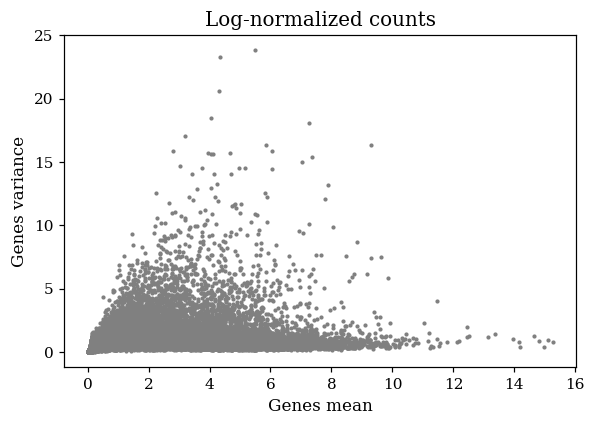

In [103]:
bulk.reload()
bulk.lib_size_normalization(tot = 1e6, ow = True)
bulk.save()

#### PSEUDOBULK

CPM normalization...


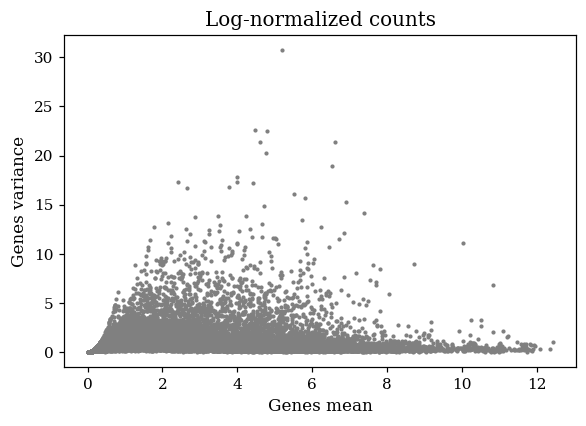

In [104]:
pseudobulk.reload()
pseudobulk.lib_size_normalization(tot = 1e6)
pseudobulk.save()

### Correlation

In [111]:
data = RNAseq.merge_datasets([bulk, pseudobulk], annot_name = "exp_type", annot = ["bulk", "sc"])
data.annotate_samples(samples_annot_name = "index", samples_annot = [d + '_' + c for d, c in zip(data.dataset, data.cell_lines)])
data.save()

Annotating exp_type...
Annotating cell_lines...
Annotating dataset...
Annotating index...


In [1013]:
data.layers

{'full': ['log_norm_mtx', 'mtx'], 'reduced': []}

In [112]:
_, i_bulk = data.select_samples(samples_annot_name = "exp_type", samples_annot = "bulk", return_annot = "index")
# i_bulk_geo = data.select_samples(annot_name = "dataset", annot = "bulk-geo", return_annot = "index")
_, i_sc = data.select_samples(samples_annot_name = "exp_type", samples_annot = "sc", return_annot = "index")

corr = pd.DataFrame(np.corrcoef(data.get_layer("log_norm_mtx")), index=data.index, columns=data.index)

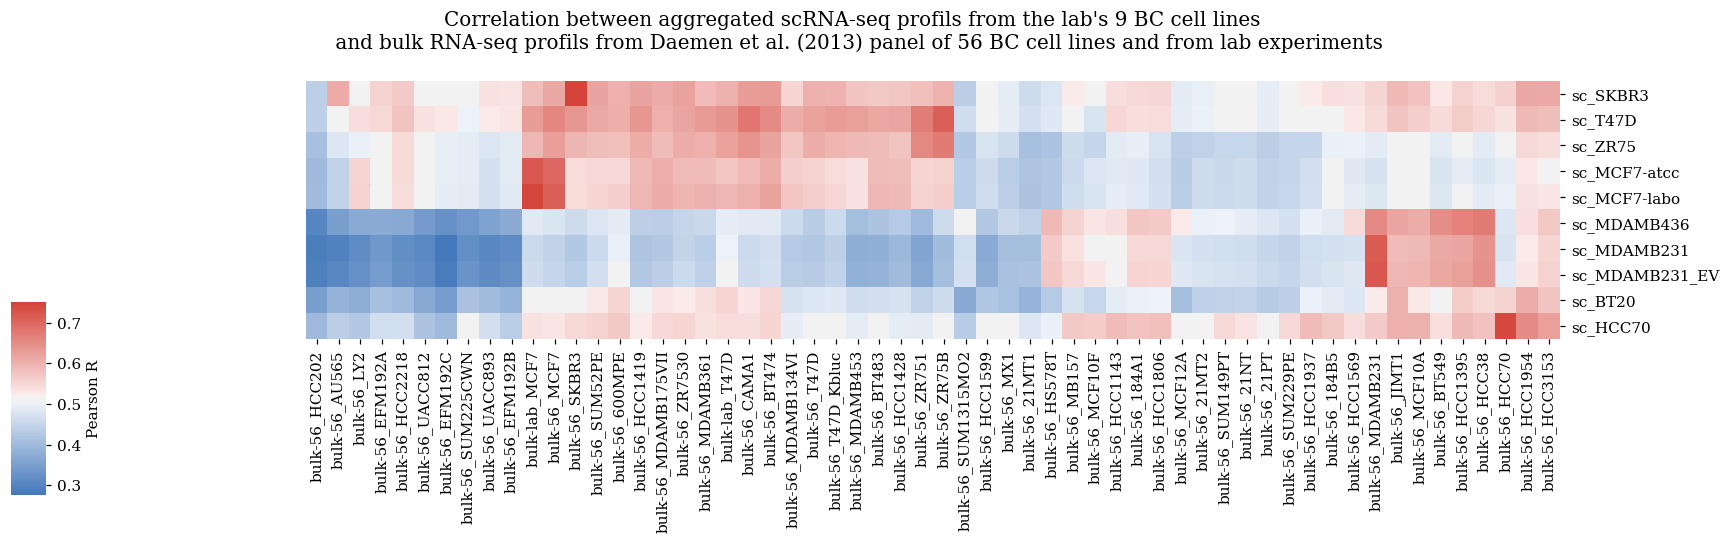

In [113]:
row_label = ['sc_T47D']
col_label = ['bulk-lab_T47D', 'bulk-56_T47D']


df = corr[i_bulk].loc[i_sc]

cmap = sb.diverging_palette(250, 14, as_cmap=True)
g = sb.clustermap(df, cmap=cmap, figsize = (16,5), cbar_pos=(0.02, 0.1, 0.02, 0.35), cbar_kws={'label': 'Pearson R'})
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
                                      
plt.suptitle("Correlation between aggregated scRNA-seq profils from the lab's 9 BC cell lines \n and bulk RNA-seq profils from Daemen et al. (2013) panel of 56 BC cell lines and from lab experiments", fontsize=13);

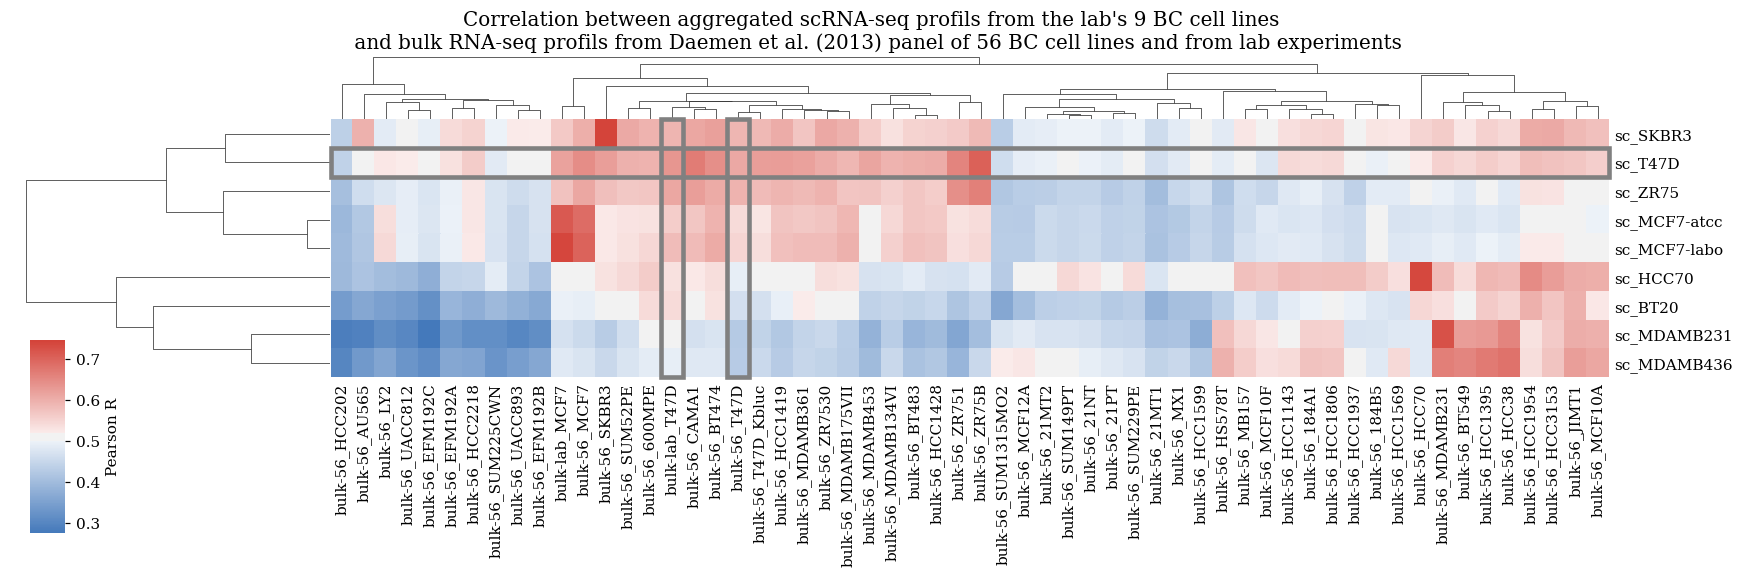

In [219]:
row_label = ['sc_T47D']
col_label = ['bulk-lab_T47D', 'bulk-56_T47D']


df = corr[i_bulk].loc[i_sc]

cmap = sb.diverging_palette(250, 14, as_cmap=True)
g = sb.clustermap(df, cmap=cmap, figsize = (16,5), cbar_pos=(0.02, 0.1, 0.02, 0.35), cbar_kws={'label': 'Pearson R'})


for r in row_label :
    wanted_row = np.argwhere(df.index[g.dendrogram_row.reordered_ind] == r)
    x, y, w, h  = (0, wanted_row, len(df.columns), 1)
    g.ax_heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor=b["T47D"], lw=3, clip_on=False))
    g.ax_heatmap.tick_params(length=0)


for c in col_label :
    wanted_col = np.argwhere(df.columns[g.dendrogram_col.reordered_ind] == c)
    x, y, w, h = (wanted_col, 0, 1, len(df.index))
    g.ax_heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor=b["T47D"], lw=3, clip_on=False))
    g.ax_heatmap.tick_params(length=0)
                                      
                                      
plt.suptitle("Correlation between aggregated scRNA-seq profils from the lab's 9 BC cell lines \n and bulk RNA-seq profils from Daemen et al. (2013) panel of 56 BC cell lines and from lab experiments", y=1.05, fontsize=13);

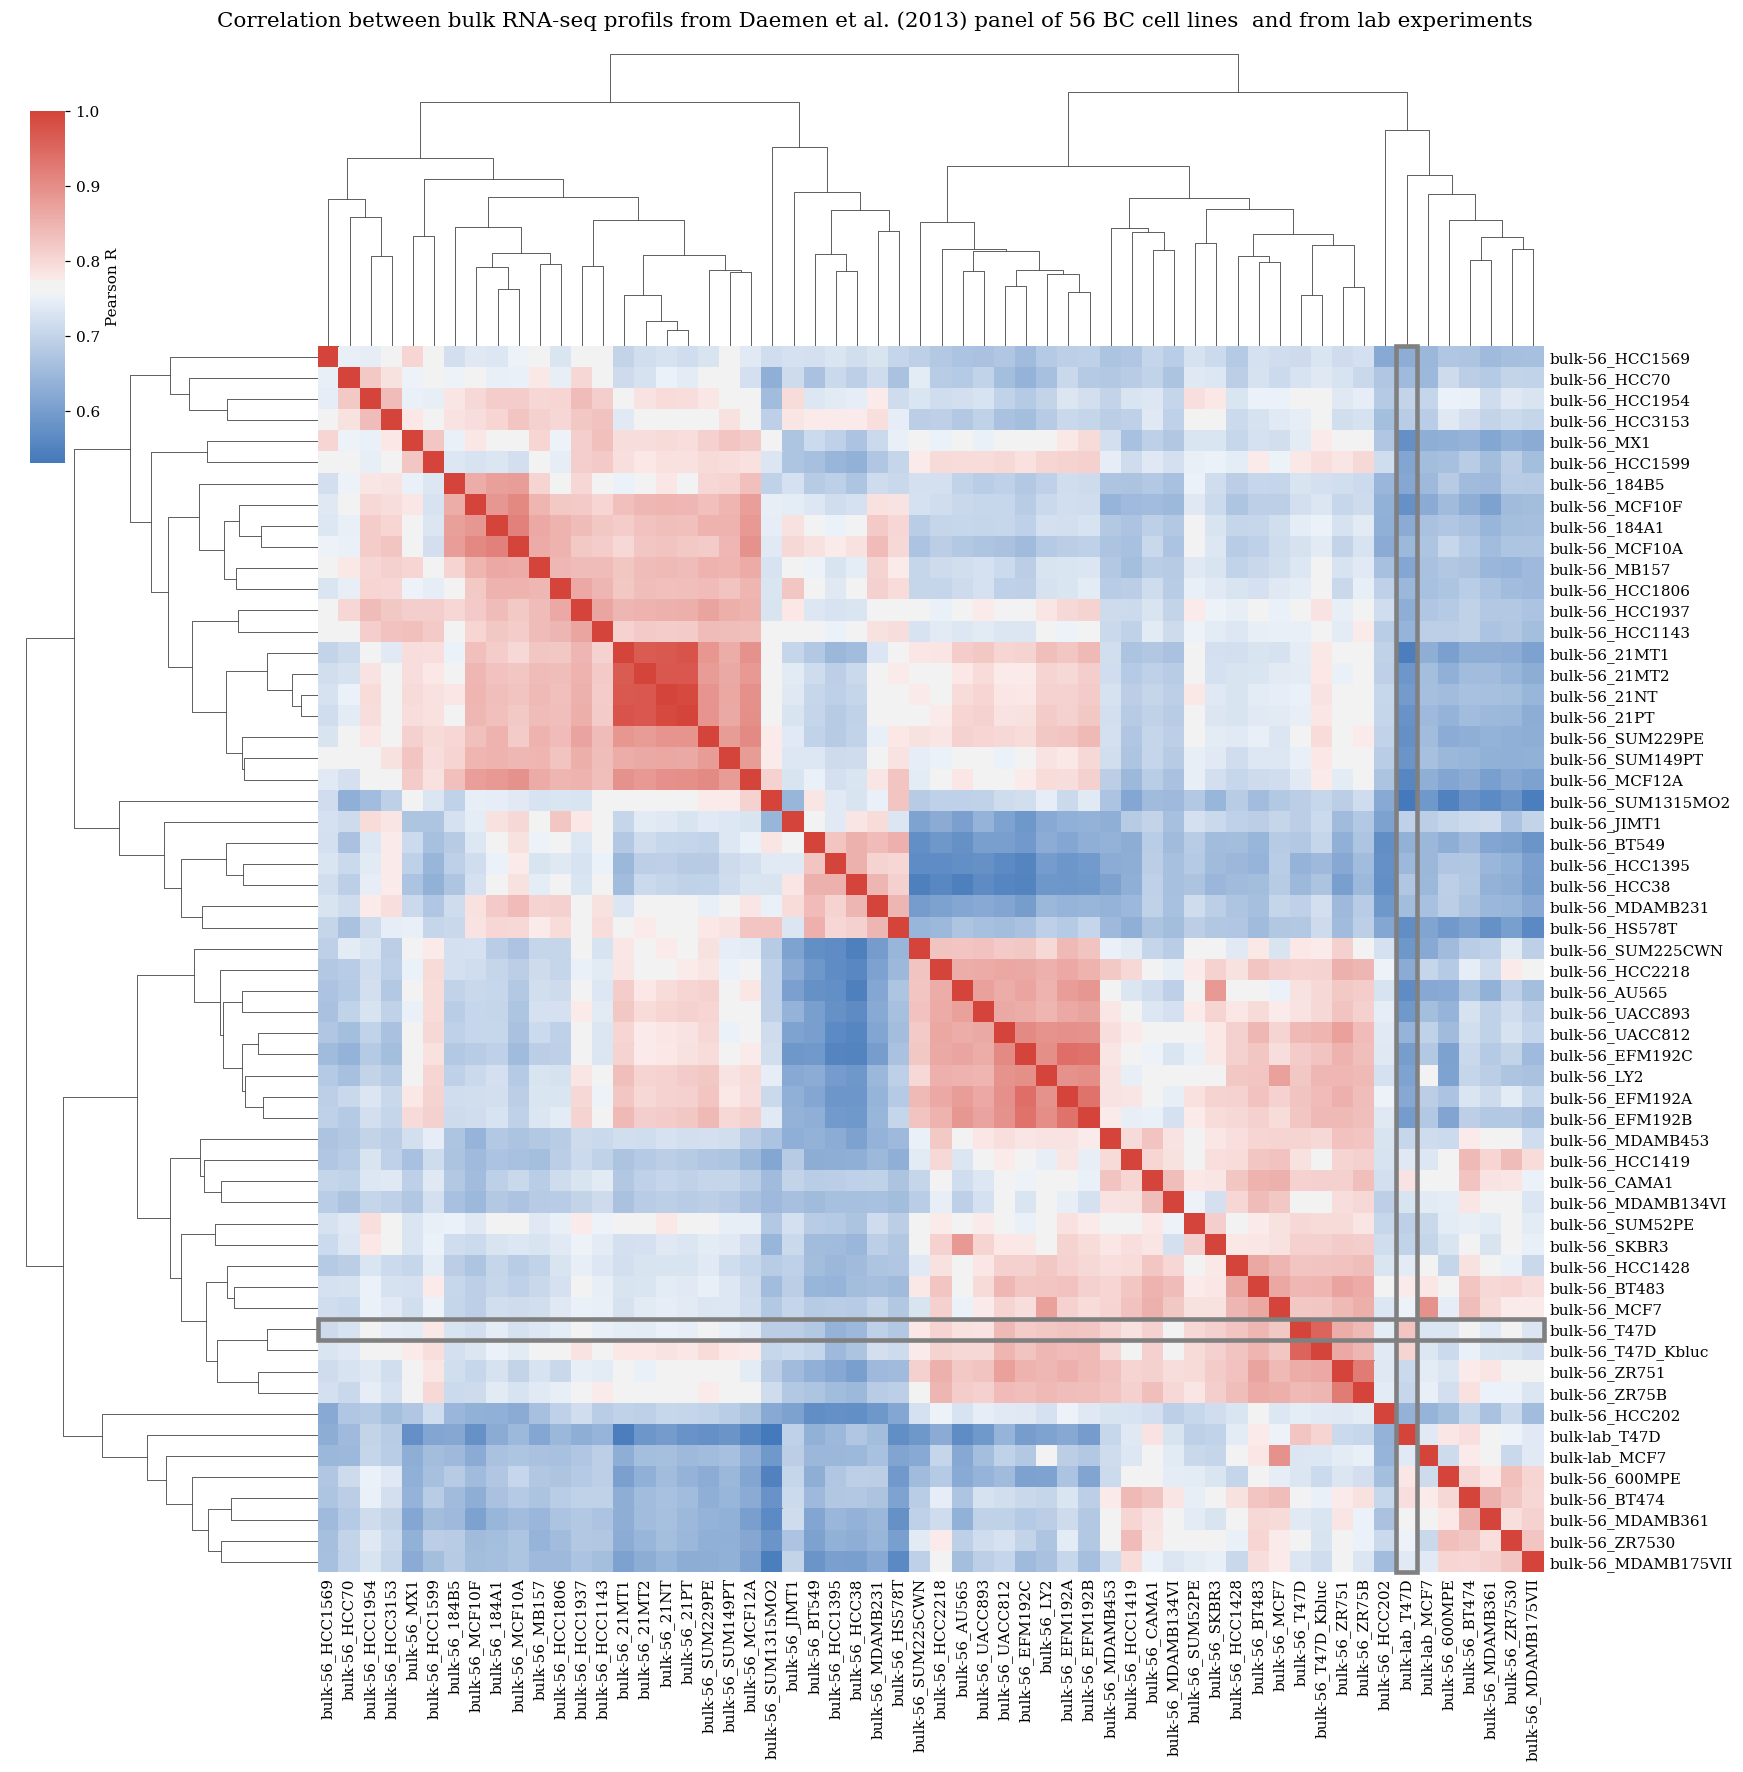

In [227]:
row_label = ['bulk-56_T47D']
col_label = ['bulk-lab_T47D']

df = corr[i_bulk].loc[i_bulk]

cmap = sb.diverging_palette(250, 14, as_cmap=True)
g = sb.clustermap(df, cmap=cmap, figsize = (16,16), cbar_pos=(0.02, 0.75, 0.02, 0.2), cbar_kws={'label': 'Pearson R'})


for r in row_label :
    wanted_row = np.argwhere(df.index[g.dendrogram_row.reordered_ind] == r)
    x, y, w, h  = (0, wanted_row, len(df.columns), 1)
    g.ax_heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor=b["T47D"], lw=3, clip_on=False))
    g.ax_heatmap.tick_params(length=0)


for c in col_label :
    wanted_col = np.argwhere(df.columns[g.dendrogram_col.reordered_ind] == c)
    x, y, w, h = (wanted_col, 0, 1, len(df.index))
    g.ax_heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor=b["T47D"], lw=3, clip_on=False))
    g.ax_heatmap.tick_params(length=0)


plt.suptitle("Correlation between bulk RNA-seq profils from Daemen et al. (2013) panel of 56 BC cell lines  and from lab experiments", y=1.007, fontsize=14);

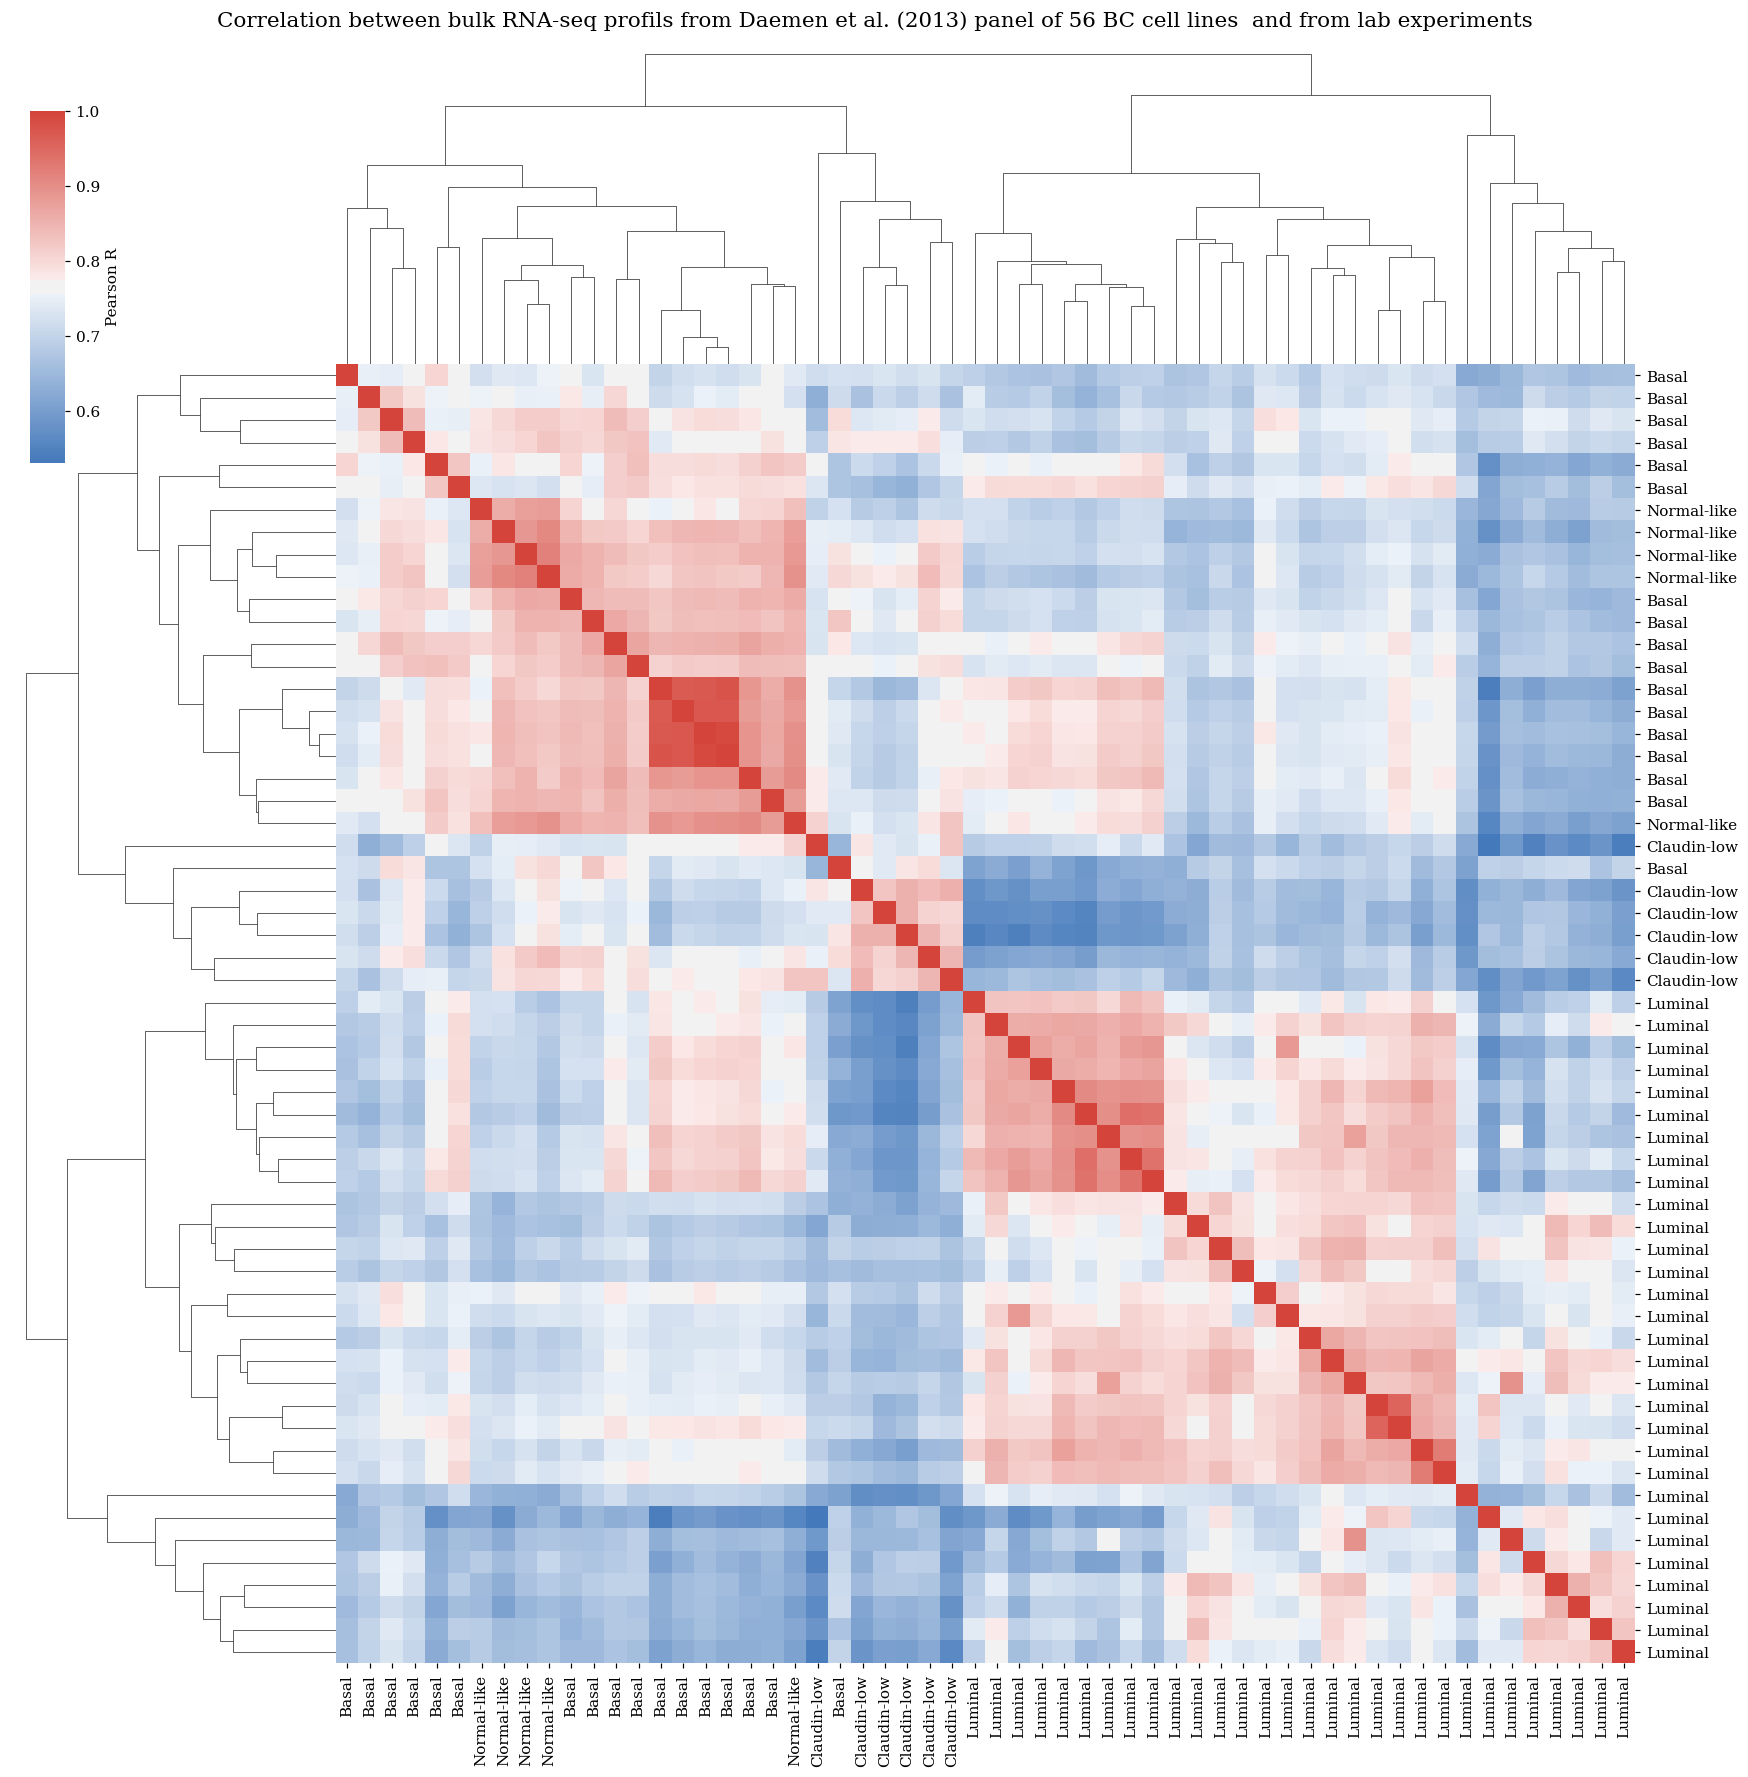

In [226]:
subtypes = data.select_samples(annot_name = "exp_type", annot = "bulk", return_annot = "subtypes")
df = pd.DataFrame(corr[i_bulk].loc[i_bulk].values, index = subtypes, columns=subtypes)

cmap = sb.diverging_palette(250, 14, as_cmap=True)
g = sb.clustermap(df, cmap=cmap, figsize = (16,16), cbar_pos=(0.02, 0.75, 0.02, 0.2), cbar_kws={'label': 'Pearson R'})


plt.suptitle("Correlation between bulk RNA-seq profils from Daemen et al. (2013) panel of 56 BC cell lines  and from lab experiments", y=1.007, fontsize=14);